<br>
<font>
<div dir=ltr align=center>
<font color=0 size=6>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=250 height=250> <br>
<font color=0F5298 size=7>
Introduction to Machine Learning <br>
<font color=2565AE size=5>
Dr. Mohammad Hossein Yassaee<br>
<font color="green" size=5>
Adel Movahedian -
Mehdi zolfaghari<br>
<font color=2565AE size=5>
winter 2024<br>


# Question 1:<br>
 Using the MNIST dataset and employing a Safe Boltzmann Machine as a feature extractor, perform a classification task and compare its performance with a standard Boltzmann Machine.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


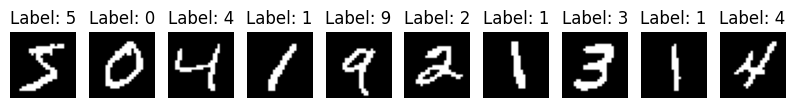

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

def preprocess_mnist(threshold=128):
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    train_images = train_images.reshape(-1, 28 * 28) / 255.0
    test_images = test_images.reshape(-1, 28 * 28) / 255.0

    train_images = (train_images > threshold / 255.0).astype(np.float32)
    test_images = (test_images > threshold / 255.0).astype(np.float32)

    return train_images, train_labels, test_images, test_labels

def show_samples(images, labels, num_samples=10):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

train_images, train_labels, test_images, test_labels = preprocess_mnist()

show_samples(train_images, train_labels, num_samples=10)



In [2]:
import torch
import torch.nn as nn
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
##################
#      RBM       #
##################
class RBM(nn.Module):
    def __init__(self, num_visible, num_hidden, lr=0.01):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.lr = lr
        # Initialize weights using Xavier to avoid possible gradient exploding
        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        nn.init.xavier_normal_(self.W, gain=0.01)
        self.v_bias = nn.Parameter(torch.zeros(num_visible))
        self.h_bias = nn.Parameter(torch.zeros(num_hidden))

    def sample_hidden(self, v):
        if not isinstance(v, torch.Tensor):
          v = torch.tensor(v, dtype=torch.float32)
        activation = v @ self.W + self.h_bias  #  @ : matrix multiplication
        prob_h = torch.sigmoid(activation)
        sample_h = torch.bernoulli(prob_h)
        return prob_h, sample_h

    def sample_visible(self, h):
        if not isinstance(h, torch.Tensor):
          h = torch.tensor(h, dtype=torch.float32)
        activation = h @ self.W.t() + self.v_bias
        prob_v = torch.sigmoid(activation)
        sample_v = torch.bernoulli(prob_v)
        return prob_v, sample_v

    def contrastive_divergence(self, v0):
        if not isinstance(v0, torch.Tensor):
          v0 = torch.tensor(v0, dtype=torch.float32)
        p_h0, h0 = self.sample_hidden(v0) # Sample hidden units given the initial visible states
        p_v, v1 = self.sample_visible(h0) # Reconstruct the visible states from hidden samples
        p_h1, _ = self.sample_hidden(v1) # Sample hidden units again from the reconstructed visibles

        loss = torch.mean((v0 - v1) ** 2) # MSE

        batch_size = v0.size(0)
        with torch.no_grad():
            self.W += self.lr * ((v0.t() @ p_h0) - (v1.t() @ p_h1)) / batch_size
            self.v_bias += self.lr * torch.mean(v0 - v1, dim=0)
            self.h_bias += self.lr * torch.mean(p_h0 - p_h1, dim=0)
        return loss

    def train_rbm(self, train_images, epochs=10, batch_size=20):
        num_samples = len(train_images)
        for epoch in range(1, epochs + 1):
            epoch_loss = 0.0
            for start in range(0, num_samples, batch_size):
                batch = train_images[start:start + batch_size]
                loss = self.contrastive_divergence(batch)
                epoch_loss += loss.item()
            avg_loss = epoch_loss / (num_samples / batch_size)
            print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")
        print("RBM is trained.")

    def free_energy(self, v): # with this function we measure the quality of given visible state.
        v_transpose_bias = -v @ self.v_bias
        # instead of (log(1 + exp(x))) we use torch.log1p for numerical stability
        hidden_term = -torch.sum(torch.log1p(torch.exp(v @ self.W + self.h_bias)), dim=1)
        return v_transpose_bias + hidden_term

##################
#     ElGamal    #
##################
class ElGamal:
    def __init__(self, prime=99991, generator=2):
        self.prime = prime
        self.generator = generator
        self.private_key = random.randint(1, self.prime - 2)
        self.public_key = pow(self.generator, self.private_key, self.prime) # generator to the power of private_key, modulus prime

    def encrypt(self, message):
        if isinstance(message, float):
            message = int(message * 10**6) # if the message is fload the message scales into int.
        message = message % self.prime  # Ensure the message is within the valid range.
        ephemeral_key = random.randint(1, self.prime - 2) # Select a random ephemeral key.
        first_component = pow(self.generator, ephemeral_key, self.prime)
        second_component = (message * pow(self.public_key, ephemeral_key, self.prime)) % self.prime
        return first_component, second_component

    def decrypt(self, c1, c2):
        shared_secret = pow(c1, self.private_key, self.prime)
        # Calculate its modular inverse using Fermat's little theorem.
        inverse_secret = pow(shared_secret, self.prime - 2, self.prime)
        decrypted_value = (c2 * inverse_secret) % self.prime
        if decrypted_value > self.prime // 2:
            decrypted_value -= self.prime
        return decrypted_value / 10**6

##################
#    SecureRBM   #
##################
class SecureRBM(nn.Module):
    def __init__(self, num_visible, num_hidden, lr=0.01, encryption_scheme=None):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.lr = lr
        self.crypto = encryption_scheme or ElGamal()
        self.W = nn.Parameter(torch.randn(num_visible, num_hidden) * 0.01)
        self.v_bias = nn.Parameter(torch.zeros(num_visible))
        self.h_bias = nn.Parameter(torch.zeros(num_hidden))
        self.W_encrypted, self.v_bias_encrypted, self.h_bias_encrypted = [], [], []
        self.encrypt_parameters()

    def encrypt_parameters(self):
        # Encrypts the model parameters and stores them separately.
        with torch.no_grad():
            self.W_encrypted = [[self.crypto.encrypt(float(w)) for w in row] for row in self.W]
            self.v_bias_encrypted = [self.crypto.encrypt(float(v)) for v in self.v_bias]
            self.h_bias_encrypted = [self.crypto.encrypt(float(h)) for h in self.h_bias]

    def decrypt_parameters(self):
        # Decrypts and returns the model parameters as tensors.
        with torch.no_grad():
            W_decrypted = torch.tensor([[self.crypto.decrypt(*w) for w in row] for row in self.W_encrypted], dtype=torch.float32)
            v_bias_decrypted = torch.tensor([self.crypto.decrypt(*v) for v in self.v_bias_encrypted], dtype=torch.float32)
            h_bias_decrypted = torch.tensor([self.crypto.decrypt(*h) for h in self.h_bias_encrypted], dtype=torch.float32)
        return W_decrypted, v_bias_decrypted, h_bias_decrypted

    def sample_hidden(self, v):
        if not isinstance(v, torch.Tensor):
          v = torch.tensor(v, dtype=torch.float32)
        prob_h = torch.sigmoid(v @ self.W + self.h_bias)
        sample_h = torch.bernoulli(prob_h)
        return prob_h, sample_h

    def sample_visible(self, h):
        if not isinstance(h, torch.Tensor):
          h = torch.tensor(h, dtype=torch.float32)
        prob_v = torch.sigmoid(h @ self.W.t() + self.v_bias)
        sample_v = torch.bernoulli(prob_v)
        return prob_v, sample_v

    def contrastive_divergence(self, v0):
        if not isinstance(v0, torch.Tensor):
          v0 = torch.tensor(v0, dtype=torch.float32)
        _, h0 = self.sample_hidden(v0)
        _, v_k = self.sample_visible(h0)
        _, h_k = self.sample_hidden(v_k)
        loss = torch.mean((v0 - v_k) ** 2)

        with torch.no_grad():
            self.W += self.lr * ((v0.t() @ h0) - (v_k.t() @ h_k)) / v0.size(0)
            self.v_bias += self.lr * torch.mean(v0 - v_k, dim=0)
            self.h_bias += self.lr * torch.mean(h0 - h_k, dim=0)
        return loss

    def train_rbm(self, data, epochs=10, batch_size=20):
        for epoch in range(1, epochs + 1):
            self.encrypt_parameters()
            total_loss = 0.0
            for i in range(0, len(data), batch_size):
                batch = data[i: i + batch_size]
                total_loss += self.contrastive_divergence(batch).item()

            avg_loss = total_loss / (len(data) / batch_size)
            print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")
            self.decrypt_parameters()
        print("Secure RBM is trained")



def get_hidden_features(model, data):
    data_tensor = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        _, hidden_layer = model.sample_hidden(data_tensor)
    return hidden_layer.numpy()

def evaluate_classifiers(rbm_model, secure_rbm_model, train_images, train_labels , test_images, test_labels):

    # Extract features from simple RBM :
    features_train_rbm = get_hidden_features(rbm_model, train_images)
    features_test_rbm = get_hidden_features(rbm_model, test_images)
    # Extract features from Secure RBM :
    features_train_secure = get_hidden_features(secure_rbm_model, train_images)
    features_test_secure = get_hidden_features(secure_rbm_model, test_images)

    # Initialise and train logistic regression for RBM features
    classifier_rbm = LogisticRegression(max_iter=10000)
    classifier_rbm.fit(features_train_rbm, train_labels)
    predictions_rbm = classifier_rbm.predict(features_test_rbm)
    accuracy_rbm = accuracy_score(test_labels, predictions_rbm)

    # Initialise and train logistic regression for SecureRBM features
    classifier_secure = LogisticRegression(max_iter=10000)
    classifier_secure.fit(features_train_secure, train_labels)
    predictions_secure = classifier_secure.predict(features_test_secure)
    accuracy_secure = accuracy_score(test_labels, predictions_secure)

    print("RBM Feature Accuracy: {:.4f}".format(accuracy_rbm))
    print("SecureRBM Feature Accuracy: {:.4f}".format(accuracy_secure))

    return accuracy_rbm, accuracy_secure


In [3]:
rbm = RBM(num_visible=784, num_hidden=256, lr=0.01)
secure_rbm = SecureRBM(num_visible=784, num_hidden=256, lr=0.01, encryption_scheme=ElGamal())
rbm.train_rbm(train_images, epochs=20)
secure_rbm.train_rbm(train_images, epochs=20)
rbm_acc, secure_acc= evaluate_classifiers(rbm, secure_rbm, train_images, train_labels, test_images, test_labels)

Epoch 1, Average Loss: 0.1325
Epoch 2, Average Loss: 0.0875
Epoch 3, Average Loss: 0.0741
Epoch 4, Average Loss: 0.0669
Epoch 5, Average Loss: 0.0619
Epoch 6, Average Loss: 0.0584
Epoch 7, Average Loss: 0.0555
Epoch 8, Average Loss: 0.0532
Epoch 9, Average Loss: 0.0513
Epoch 10, Average Loss: 0.0497
Epoch 11, Average Loss: 0.0482
Epoch 12, Average Loss: 0.0469
Epoch 13, Average Loss: 0.0458
Epoch 14, Average Loss: 0.0447
Epoch 15, Average Loss: 0.0438
Epoch 16, Average Loss: 0.0430
Epoch 17, Average Loss: 0.0422
Epoch 18, Average Loss: 0.0416
Epoch 19, Average Loss: 0.0410
Epoch 20, Average Loss: 0.0404
RBM is trained.
Epoch 1, Average Loss: 0.1149
Epoch 2, Average Loss: 0.0792
Epoch 3, Average Loss: 0.0692
Epoch 4, Average Loss: 0.0632
Epoch 5, Average Loss: 0.0593
Epoch 6, Average Loss: 0.0563
Epoch 7, Average Loss: 0.0539
Epoch 8, Average Loss: 0.0519
Epoch 9, Average Loss: 0.0502
Epoch 10, Average Loss: 0.0488
Epoch 11, Average Loss: 0.0475
Epoch 12, Average Loss: 0.0464
Epoch 13, 

<font color="green">Secure RBM provides privacy-preserving learning but may slightly reduce classification accuracy compared to standard RBM because of encryption and decryption we did.

# Question 2:
using the p(x,y) as loss function, implimenting the RBM as bellow:

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class RBM:
    def __init__(self, n_visible, n_hidden, n_classes):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_classes = n_classes

        # Parameters
        self.W = np.random.randn(n_hidden, n_visible) * 0.01  # Weights (hidden x visible)
        self.U = np.random.randn(n_hidden, n_classes) * 0.01  # Weights (hidden x class)
        self.b = np.zeros(n_visible)  # Visible bias (input)
        self.c = np.zeros(n_hidden)   # Hidden bias
        self.d = np.zeros(n_classes)  # Class bias

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    def sample_hidden(self, x, y):
        """Sample hidden units given x and y."""
        activation = self.c + np.dot(self.W, x) + self.U[:, y]
        p_h = self.sigmoid(activation)
        return p_h, np.random.binomial(1, p_h)

    def sample_visible(self, h):
        """Sample x and y given hidden units."""
        # Sample x (binary)
        activation_x = self.b + np.dot(self.W.T, h)
        p_x = self.sigmoid(activation_x)
        x_recon = np.random.binomial(1, p_x)

        # Sample y (softmax)
        activation_y = self.d + np.dot(self.U.T, h)
        p_y = self.softmax(activation_y)
        y_recon = np.random.choice(self.n_classes, p=p_y)
        return x_recon, y_recon
    # attribute used to evaluate the model
    def p_y_given_x(self, x):
        """Compute p(y|x) using exact inference."""
        # Shape: (n_hidden, n_classes)
        activation = self.c[:, np.newaxis] + np.dot(self.W, x)[:, np.newaxis] + self.U
        log_terms = np.log(1 + np.exp(activation))
        sum_log_terms = np.sum(log_terms, axis=0)  # Sum over hidden units
        logits = self.d + sum_log_terms
        return self.softmax(logits)

    def generative_gradient(self, x, y, n_gibbs=1):
        """Compute generative gradient using Contrastive Divergence (CD-k)."""
        # Positive phase
        p_h_pos, h_pos = self.sample_hidden(x, y)

        # Negative phase (CD-1)
        x_neg, y_neg = x.copy(), y
        for _ in range(n_gibbs):
            # Sample y_neg from p(y|h_pos)
            p_y_neg = self.softmax(self.d + np.dot(self.U.T, h_pos))
            y_neg = np.random.choice(self.n_classes, p=p_y_neg)
            # Sample x_neg from p(x|h_pos)
            p_x_neg = self.sigmoid(self.b + np.dot(self.W.T, h_pos))
            x_neg = np.random.binomial(1, p_x_neg)
            # Sample h_neg from p(h|x_neg, y_neg)
            _, h_neg = self.sample_hidden(x_neg, y_neg)

        # Compute gradients
        #each parameter (theta) undergoes the positive and negative phase as shown in the given algorithm
        #gradient of Lgenerative w.r.t W,U,b,c,d
        grad_W = np.outer(h_pos, x) - np.outer(h_neg, x_neg)
        grad_U = np.zeros_like(self.U)
        grad_U[:, y] = h_pos
        grad_U[:, y_neg] -= h_neg
        grad_b = x - x_neg
        grad_c = h_pos - h_neg
        grad_d = np.zeros(self.n_classes)
        grad_d[y] = 1
        grad_d[y_neg] -= 1

        return {'W': grad_W, 'U': grad_U, 'b': grad_b, 'c': grad_c, 'd': grad_d}
    # updating parameters with learning rate lr and gradients calculated above
    def update_parameters(self, grads, lr):
        """Update parameters with gradients."""
        self.W += lr * grads.get('W', 0)
        self.U += lr * grads.get('U', 0)
        self.b += lr * grads.get('b', 0)
        self.c += lr * grads.get('c', 0)
        self.d += lr * grads.get('d', 0)

    def train(self, labeled_data, lr=0.01, epochs=10):
        """Training loop for RBM."""
        for _ in range(epochs):
            np.random.shuffle(labeled_data)
            for x, y in labeled_data:
                gen_grads = self.generative_gradient(x, y)
                self.update_parameters(gen_grads, lr)

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"].astype(int)

# Binarize the data
X_binarized = (X > 127).astype(int)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_binarized, y, test_size=0.2, random_state=42)

# Prepare labeled data as (input, target) pairs
labeled_data = list(zip(X_train.values, y_train))

# Initialize RBM
n_visible = 784  # 28x28 pixels
n_hidden = 200   # Number of hidden units
n_classes = 10   # Digits 0-9
rbm = RBM(n_visible, n_hidden, n_classes)

# Train RBM
rbm.train(labeled_data, lr=0.01, epochs=10)

# Evaluate p(y|x) on the test set
y_pred = []
for x in X_test.values:
    p_y = rbm.p_y_given_x(x)
    y_pred.append(np.argmax(p_y))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

C:\Users\zoli\anaconda3\envs\python38\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Test Accuracy: 91.86%


# Question 3:

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class DRBM:
    def __init__(self, n_visible, n_hidden, n_classes):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_classes = n_classes

        # Parameters
        self.W = np.random.randn(n_hidden, n_visible) * 0.01  # Weights (hidden x visible)
        self.U = np.random.randn(n_hidden, n_classes) * 0.01  # Weights (hidden x class)
        self.b = np.zeros(n_visible)  # Visible bias (input)
        self.c = np.zeros(n_hidden)   # Hidden bias
        self.d = np.zeros(n_classes)  # Class bias

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    def sample_hidden(self, x, y):
        """Sample hidden units given x and y."""
        activation = self.c + np.dot(self.W, x) + self.U[:, y]
        p_h = self.sigmoid(activation)
        return p_h, np.random.binomial(1, p_h)

    def p_y_given_x(self, x):
        """Compute p(y|x) using exact inference."""
        # Shape: (n_hidden, n_classes)
        activation = self.c[:, np.newaxis] + np.dot(self.W, x)[:, np.newaxis] + self.U
        log_terms = np.log(1 + np.exp(activation))
        sum_log_terms = np.sum(log_terms, axis=0)  # Sum over hidden units
        logits = self.d + sum_log_terms
        return self.softmax(logits)

    def discriminative_gradient(self, x, y):
        """Compute exact gradient for discriminative loss (log p(y|x))."""
        p_y = self.p_y_given_x(x)
        o_matrix = self.c[:, np.newaxis] + np.dot(self.W, x)[:, np.newaxis] + self.U
        sigmoid_o = self.sigmoid(o_matrix)

        # Gradients of Ldiscriminative w.r.t c, W, U, d
        positive_contrib = sigmoid_o[:, y]
        negative_contrib = np.dot(sigmoid_o, p_y)

        grad_c = positive_contrib - negative_contrib
        grad_W = np.outer(grad_c, x)
        grad_U = np.zeros_like(self.U)
        grad_U[:, y] = positive_contrib
        grad_U -= sigmoid_o * p_y[np.newaxis, :]

        grad_d = np.zeros(self.n_classes)
        grad_d[y] = 1
        grad_d -= p_y

        return {'W': grad_W, 'U': grad_U, 'c': grad_c, 'd': grad_d}

    def update_parameters(self, grads, lr):
        """Update parameters with gradients."""
        self.W += lr * grads.get('W', 0)
        self.U += lr * grads.get('U', 0)
        self.b += lr * grads.get('b', 0)
        self.c += lr * grads.get('c', 0)
        self.d += lr * grads.get('d', 0)

    def train(self, labeled_data, lr=0.01, epochs=10):
        """Training loop for DRBM."""
        for _ in range(epochs):
            np.random.shuffle(labeled_data)
            for x, y in labeled_data:
                disc_grads = self.discriminative_gradient(x, y)
                self.update_parameters(disc_grads, lr)

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"].astype(int)

# Binarize the data
X_binarized = (X > 127).astype(int)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_binarized, y, test_size=0.2, random_state=42)

# Prepare labeled data as (input, target) pairs
labeled_data = list(zip(X_train.values, y_train))

# Initialize DRBM
n_visible = 784  # 28x28 pixels
n_hidden = 200   # Number of hidden units
n_classes = 10   # Digits 0-9
drbm = DRBM(n_visible, n_hidden, n_classes)

# Train DRBM
drbm.train(labeled_data, lr=0.01, epochs=10)

# Evaluate p(y|x) on the test set
y_pred = []
for x in X_test.values:
    p_y = drbm.p_y_given_x(x)
    y_pred.append(np.argmax(p_y))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

C:\Users\zoli\anaconda3\envs\python38\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Test Accuracy: 97.00%


# Question 4:
in each epoch, we used a combination of lgen and ldisc in order to lower the summation with a factor alpha

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class HDRBM:
    def __init__(self, n_visible, n_hidden, n_classes):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_classes = n_classes

        # Parameters
        self.W = np.random.randn(n_hidden, n_visible) * 0.01  # Weights (hidden x visible)
        self.U = np.random.randn(n_hidden, n_classes) * 0.01  # Weights (hidden x class)
        self.b = np.zeros(n_visible)  # Visible bias (input)
        self.c = np.zeros(n_hidden)   # Hidden bias
        self.d = np.zeros(n_classes)  # Class bias

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    def sample_hidden(self, x, y):
        """Sample hidden units given x and y."""
        activation = self.c + np.dot(self.W, x) + self.U[:, y]
        p_h = self.sigmoid(activation)
        return p_h, np.random.binomial(1, p_h)

    def sample_visible(self, h):
        """Sample x and y given hidden units."""
        # Sample x (binary)
        activation_x = self.b + np.dot(self.W.T, h)
        p_x = self.sigmoid(activation_x)
        x_recon = np.random.binomial(1, p_x)

        # Sample y (softmax)
        activation_y = self.d + np.dot(self.U.T, h)
        p_y = self.softmax(activation_y)
        y_recon = np.random.choice(self.n_classes, p=p_y)
        return x_recon, y_recon

    def p_y_given_x(self, x):
        """Compute p(y|x) using exact inference."""
        # Shape: (n_hidden, n_classes)
        activation = self.c[:, np.newaxis] + np.dot(self.W, x)[:, np.newaxis] + self.U
        log_terms = np.log(1 + np.exp(activation))
        sum_log_terms = np.sum(log_terms, axis=0)  # Sum over hidden units
        logits = self.d + sum_log_terms
        return self.softmax(logits)

    def discriminative_gradient(self, x, y):
        """Compute exact gradient for discriminative loss (log p(y|x))."""
        p_y = self.p_y_given_x(x)
        o_matrix = self.c[:, np.newaxis] + np.dot(self.W, x)[:, np.newaxis] + self.U
        sigmoid_o = self.sigmoid(o_matrix)

        # Gradients for c, W, U, d
        positive_contrib = sigmoid_o[:, y]
        negative_contrib = np.dot(sigmoid_o, p_y)

        grad_c = positive_contrib - negative_contrib
        grad_W = np.outer(grad_c, x)
        grad_U = np.zeros_like(self.U)
        grad_U[:, y] = positive_contrib
        grad_U -= sigmoid_o * p_y[np.newaxis, :]

        grad_d = np.zeros(self.n_classes)
        grad_d[y] = 1
        grad_d -= p_y

        return {'W': grad_W, 'U': grad_U, 'c': grad_c, 'd': grad_d}

    def generative_gradient(self, x, y, n_gibbs=1):
        """Compute generative gradient using Contrastive Divergence (CD-k)."""
        # Positive phase
        p_h_pos, h_pos = self.sample_hidden(x, y)

        # Negative phase (CD-1)
        x_neg, y_neg = x.copy(), y
        for _ in range(n_gibbs):
            # Sample y_neg from p(y|h_pos)
            p_y_neg = self.softmax(self.d + np.dot(self.U.T, h_pos))
            y_neg = np.random.choice(self.n_classes, p=p_y_neg)
            # Sample x_neg from p(x|h_pos)
            p_x_neg = self.sigmoid(self.b + np.dot(self.W.T, h_pos))
            x_neg = np.random.binomial(1, p_x_neg)
            # Sample h_neg from p(h|x_neg, y_neg)
            _, h_neg = self.sample_hidden(x_neg, y_neg)

        # Compute gradients
        grad_W = np.outer(h_pos, x) - np.outer(h_neg, x_neg)
        grad_U = np.zeros_like(self.U)
        grad_U[:, y] = h_pos
        grad_U[:, y_neg] -= h_neg
        grad_b = x - x_neg
        grad_c = h_pos - h_neg
        grad_d = np.zeros(self.n_classes)
        grad_d[y] = 1
        grad_d[y_neg] -= 1

        return {'W': grad_W, 'U': grad_U, 'b': grad_b, 'c': grad_c, 'd': grad_d}

    def update_parameters(self, grads, lr):
        """Update parameters with gradients."""
        self.W += lr * grads.get('W', 0)
        self.U += lr * grads.get('U', 0)
        self.b += lr * grads.get('b', 0)
        self.c += lr * grads.get('c', 0)
        self.d += lr * grads.get('d', 0)

    def train(self, labeled_data, lr=0.01, alpha=0.1, epochs=10):
        """Training loop for HDRBM."""
        for _ in range(epochs):
            np.random.shuffle(labeled_data)
            for x, y in labeled_data:
                # Hybrid gradient: discriminative + alpha * generative
                disc_grads = self.discriminative_gradient(x, y)
                gen_grads = self.generative_gradient(x, y)
                hybrid_grads = {k: disc_grads[k] + alpha * gen_grads.get(k, 0) for k in disc_grads}
                self.update_parameters(hybrid_grads, lr)

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"].astype(int)

# Binarize the data
X_binarized = (X > 127).astype(int)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_binarized, y, test_size=0.2, random_state=42)

# Prepare labeled data as (input, target) pairs
labeled_data = list(zip(X_train.values, y_train))

# Initialize HDRBM
n_visible = 784  # 28x28 pixels
n_hidden = 200   # Number of hidden units
n_classes = 10   # Digits 0-9
hdrbm = HDRBM(n_visible, n_hidden, n_classes)

# Train HDRBM with alpha=0.1
hdrbm.train(labeled_data, lr=0.01, alpha=0.1, epochs=10)

# Evaluate p(y|x) on the test set
y_pred = []
for x in X_test.values:
    p_y = hdrbm.p_y_given_x(x)
    y_pred.append(np.argmax(p_y))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

C:\Users\zoli\anaconda3\envs\python38\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Test Accuracy: 95.90%


In [ ]:
hdrbm.train(labeled_data, lr=0.01, alpha=1, epochs=10)

# Evaluate p(y|x) on the test set
y_pred = []
for x in X_test.values:
    p_y = hdrbm.p_y_given_x(x)
    y_pred.append(np.argmax(p_y))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 94.04%


In [ ]:
hdrbm.train(labeled_data, lr=0.01, alpha=0.01, epochs=10)

# Evaluate p(y|x) on the test set
y_pred = []
for x in X_test.values:
    p_y = hdrbm.p_y_given_x(x)
    y_pred.append(np.argmax(p_y))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 96.24%


# Question 5

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the Semi-Supervised DRBM model
class SemiSupervisedDRBM:
    def __init__(self, n_visible, n_hidden, n_classes):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_classes = n_classes

        # Initialise parameters
        self.W = np.random.randn(n_hidden, n_visible) * 0.01  # Weights (hidden x visible)
        self.U = np.random.randn(n_hidden, n_classes) * 0.01    # Weights (hidden x class)
        self.b = np.zeros(n_visible)  # Visible bias
        self.c = np.zeros(n_hidden)   # Hidden bias
        self.d = np.zeros(n_classes)  # Class bias

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        # Softmax applied column-wise
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    def p_y_given_x(self, x):
        """
        Compute p(y|x) using exact inference.
        x: a 1D numpy array of length n_visible.
        Returns a probability vector of length n_classes.
        """
        # Compute activation for each class
        # For each hidden unit j, activation_j = c_j + sum_i W[j, i]*x_i and add U[j, y] per class
        activation = self.c[:, np.newaxis] + np.dot(self.W, x)[:, np.newaxis] + self.U
        # Compute free energy contribution from hidden units
        log_terms = np.log1p(np.exp(activation))  # log(1 + exp(.))
        sum_log_terms = np.sum(log_terms, axis=0)  # sum over hidden units
        logits = self.d + sum_log_terms
        return self.softmax(logits)

    def sample_hidden(self, x, y):
        """
        Sample hidden units given x and y.
        Returns the hidden probabilities and a binary sample.
        """
        activation = self.c + np.dot(self.W, x) + self.U[:, y]
        p_h = self.sigmoid(activation)
        h_sample = np.random.binomial(1, p_h)
        return p_h, h_sample

    def generative_gradient(self, x, y, n_gibbs=1):
        """
        Compute generative gradient using Contrastive Divergence (CD-k).
        This function is similar to the one used in HDRBM.
        """
        # Positive phase
        p_h_pos, h_pos = self.sample_hidden(x, y)

        # Negative phase (CD-1)
        x_neg, y_neg = x.copy(), y
        for _ in range(n_gibbs):
            # Sample y_neg from p(y|h_pos)
            p_y_neg = self.softmax(self.d + np.dot(self.U.T, h_pos))
            y_neg = np.random.choice(self.n_classes, p=p_y_neg)
            # Sample x_neg from p(x|h_pos)
            p_x_neg = self.sigmoid(self.b + np.dot(self.W.T, h_pos))
            x_neg = np.random.binomial(1, p_x_neg)
            # Sample h_neg from p(h|x_neg, y_neg)
            _, h_neg = self.sample_hidden(x_neg, y_neg)

        # Compute gradients (similar to HDRBM)
        grad_W = np.outer(h_pos, x) - np.outer(h_neg, x_neg)
        grad_U = np.zeros_like(self.U)
        grad_U[:, y] = h_pos
        grad_U[:, y_neg] -= h_neg
        grad_b = x - x_neg
        grad_c = h_pos - h_neg
        grad_d = np.zeros(self.n_classes)
        grad_d[y] = 1
        grad_d[y_neg] -= 1

        return {'W': grad_W, 'U': grad_U, 'b': grad_b, 'c': grad_c, 'd': grad_d}

    def discriminative_gradient(self, x, y):
        """
        Compute the exact gradient for the discriminative loss: -log p(y|x).
        This is based on the DRBM implementation.
        """
        p_y = self.p_y_given_x(x)
        # Compute the activation matrix for the hidden layer
        activation = self.c[:, np.newaxis] + np.dot(self.W, x)[:, np.newaxis] + self.U
        sigmoid_o = self.sigmoid(activation)

        # Gradients for c, W, U, d
        positive_contrib = sigmoid_o[:, y]
        negative_contrib = np.dot(sigmoid_o, p_y)

        grad_c = positive_contrib - negative_contrib
        grad_W = np.outer(grad_c, x)
        grad_U = np.zeros_like(self.U)
        grad_U[:, y] = positive_contrib
        grad_U -= sigmoid_o * p_y[np.newaxis, :]

        grad_d = np.zeros(self.n_classes)
        grad_d[y] = 1
        grad_d -= p_y

        return {'W': grad_W, 'U': grad_U, 'c': grad_c, 'd': grad_d}

    def update_parameters(self, grads, lr):
        """Update model parameters using gradient descent."""
        self.W += lr * grads.get('W', 0)
        self.U += lr * grads.get('U', 0)
        self.b += lr * grads.get('b', 0)
        self.c += lr * grads.get('c', 0)
        self.d += lr * grads.get('d', 0)

    def train(self, labelled_data, unlabelled_data, lr=0.01, alpha=0.1, epochs=10):
        """
        Train the model with both labelled and unlabelled data.

        labelled_data: list of tuples (x, y) where x is a numpy array and y is the true label.
        unlabelled_data: list of x samples (unlabelled, but we have their x values).
        """
        # Combine labelled and unlabelled data (we treat them separately in the loop)
        for epoch in range(1, epochs + 1):
            np.random.shuffle(labelled_data)
            np.random.shuffle(unlabelled_data)

            # Process labelled samples
            for x, y in labelled_data:
                disc_grads = self.discriminative_gradient(x, y)
                gen_grads = self.generative_gradient(x, y)
                # Hybrid gradient for labelled sample
                hybrid_grads = {k: disc_grads.get(k, 0) + alpha * gen_grads.get(k, 0) for k in disc_grads}
                self.update_parameters(hybrid_grads, lr)

            # Process unlabelled samples using pseudo-labels
            for x in unlabelled_data:
                # Obtain pseudo-label from current model
                p_y = self.p_y_given_x(x)
                pseudo_y = np.argmax(p_y)
                gen_grads = self.generative_gradient(x, pseudo_y)
                # For unlabelled data we only use the generative component
                grad = {k: alpha * gen_grads.get(k, 0) for k in gen_grads}
                self.update_parameters(grad, lr)

            print(f"Epoch {epoch} completed.")

    def predict(self, x):
        """
        Predict the label for a given input sample.
        """
        p_y = self.p_y_given_x(x)
        return np.argmax(p_y)

    def evaluate(self, X_test, y_test):
        """
        Evaluate the model on the test set and print the accuracy, classification report and confusion matrix.
        """
        y_pred = []
        for x in X_test:
            y_pred.append(self.predict(x))
        acc = accuracy_score(y_test, y_pred)
        print(f"Test Accuracy: {acc * 100:.2f}%")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

# -----------------------
# Data Preparation
# -----------------------
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"].astype(int)

# Binarise the data
X_binarised = (X > 127).astype(int)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_binarised, y, test_size=0.2, random_state=42)

# -----------------------
# Create labelled and unlabelled sets
# -----------------------
def create_semisupervised_sets(X, y, labelled_fraction=1.0):
    """
    Split the training data into labelled and unlabelled sets.
    labelled_fraction: fraction of the training samples to be used as labelled data.
    """
    X_np = X.to_numpy()  # convert to NumPy array for positional indexing
    y_np = y.to_numpy()  # similarly for y
    n_samples = X_np.shape[0]
    n_labelled = int(n_samples * labelled_fraction)

    # Shuffle the indices
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    labelled_idx = indices[:n_labelled]
    unlabelled_idx = indices[n_labelled:]

    labelled_data = [(X_np[i].astype(np.float32), y_np[i]) for i in labelled_idx]
    unlabelled_data = [X_np[i].astype(np.float32) for i in unlabelled_idx]

    return labelled_data, unlabelled_data


# For fully supervised training (100% labelled)
labelled_full, unlabelled_empty = create_semisupervised_sets(X_train, y_train, labelled_fraction=1.0)
# For semi-supervised training (10% labelled)
labelled_10, unlabelled_10 = create_semisupervised_sets(X_train, y_train, labelled_fraction=0.1)
# For highly semi-supervised training (1% labelled)
labelled_1, unlabelled_1 = create_semisupervised_sets(X_train, y_train, labelled_fraction=0.01)

# -----------------------
# Initialise and Train the Model
# -----------------------
n_visible = 784   # 28x28 pixels
n_hidden = 200    # Number of hidden units
n_classes = 10    # Digits 0-9

print("Training with fully supervised data (100% labelled):")
drbm_full = SemiSupervisedDRBM(n_visible, n_hidden, n_classes)
drbm_full.train(labelled_full, unlabelled_empty, lr=0.01, alpha=0.1, epochs=10)
X_test_array = X_test.values.astype(np.float32)
drbm_full.evaluate(X_test_array, y_test)


print("\nTraining with semi-supervised data (10% labelled):")
drbm_10 = SemiSupervisedDRBM(n_visible, n_hidden, n_classes)
drbm_10.train(labelled_10, unlabelled_10, lr=0.01, alpha=0.1, epochs=10)
# Prepare X_test in the same way
X_test_array = [x.values.astype(np.float32) for i, x in X_test.iterrows()]
drbm_10.evaluate(X_test_array, y_test)

print("\nTraining with highly semi-supervised data (1% labelled):")
drbm_1 = SemiSupervisedDRBM(n_visible, n_hidden, n_classes)
drbm_1.train(labelled_1, unlabelled_1, lr=0.01, alpha=0.1, epochs=10)
drbm_1.evaluate(X_test_array, y_test)


Training with fully supervised data (100% labelled):
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Epoch 6 completed.
Epoch 7 completed.
Epoch 8 completed.
Epoch 9 completed.
Epoch 10 completed.
Test Accuracy: 95.80%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1343
           1       0.98      0.99      0.98      1600
           2       0.95      0.96      0.95      1380
           3       0.97      0.92      0.95      1433
           4       0.96      0.95      0.96      1295
           5       0.93      0.96      0.95      1273
           6       0.98      0.96      0.97      1396
           7       0.97      0.96      0.97      1503
           8       0.94      0.94      0.94      1357
           9       0.92      0.96      0.94      1420

    accuracy                           0.96     14000
   macro avg       0.96      0.96      0.96     14000
weighte